In [2]:
from pathlib import PurePath
import os
import sys
os.chdir(PurePath(os.path.abspath('')).parent)
sys.path.append(os.getcwd())

In [26]:
import numpy as np
import torch
from transformers import EsmTokenizer, EsmModel
from split_utils import read_fasta, Identity, compute_identity_stats, read_json
import matplotlib.pyplot as plt
from pyutils import progress
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#1C7ED6', '#77DD77', '#FFB347', '#FF6961', '#17BECF', '#F4D35E', "#ADFF2F", "#FF8200"])

In [3]:
|if not os.path.exists(".cache/figs"):
    os.makedirs(".cache/figs")

In [4]:
MIN_SEQ_LEN = 1
MAX_SEQ_LEN = 100

# Load data

In [5]:
# fasta = read_fasta("../data/build/dataset.fasta")
data = read_json("../data/build/dataset.json")
dataset = [int(sample["ID"]) for sample in data if MIN_SEQ_LEN <= len(sample["Sequence"]) <= MAX_SEQ_LEN]

# Split the data into two subsets

In [6]:
indices = np.arange(len(dataset))
np.random.shuffle(indices)
test_indices = indices[:int(len(dataset) * 0.2)]
train_indices = indices[int(len(dataset) * 0.2):]
train_ids = [dataset[i] for i in train_indices]
test_ids = [dataset[i] for i in test_indices]

# Assert independence between training and test sets

In [7]:
identity_calculator = Identity()

identities, true_train_set = compute_identity_stats(train_ids, test_ids, identity_calculator=identity_calculator)
if np.isnan(identities).any():
    print("Warning: There are NaN values in the identities array. This may indicate missing data for some sequences.")

 100%|████████████████████████████████████|  3804/3804 [00:13<00:00, 270.76it/s] 


In [8]:
test2train_id = identities.max(axis=1)

Max identity: 1.0
Mean identity: 0.8565410336724095
Median identity: 0.9166666666666666
Quantiles:
- 0.01 quantile: 0.375
- 0.05 quantile: 0.4717767295597484
- 0.10 quantile: 0.5789473684210527
- 0.25 quantile: 0.8
- 0.50 quantile: 0.9166666666666666
- 0.75 quantile: 0.972972972972973
- 0.90 quantile: 1.0
- 0.95 quantile: 1.0
- 0.99 quantile: 1.0
Number of sequences in the training set that are not similar to any test sequence (identity > 0.5):
2313


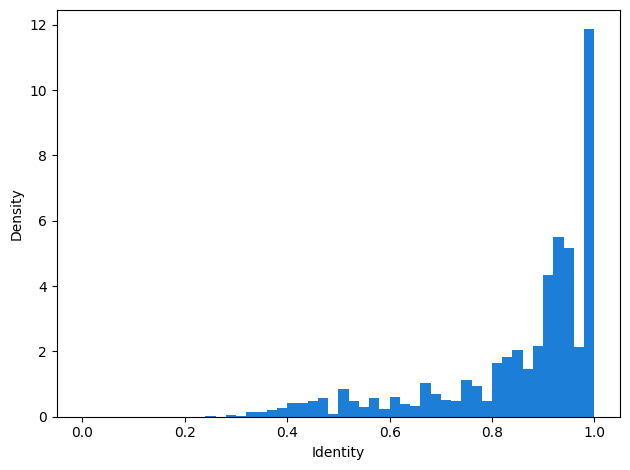

In [9]:
print(f"Max identity: {np.max(test2train_id)}")
print(f"Mean identity: {np.mean(test2train_id)}")
print(f"Median identity: {np.median(test2train_id)}")
print("Quantiles:")
for q in [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]:
    print(f"- {q:.2f} quantile: {np.quantile(test2train_id, q)}")

print("Number of sequences in the training set that are not similar to any test sequence (identity > 0.5):")
print(np.sum(true_train_set))
plt.hist(test2train_id, bins=50, range=(0, 1), density=True)
plt.xlabel("Identity")
plt.ylabel("Density")
# plt.title("Highest identity between each test sequence and all train sequences")
plt.tight_layout()
plt.savefig(".cache/figs/random_split.svg")

Text(0.5, 1.0, 'Pairwise identity distribution between train and test')

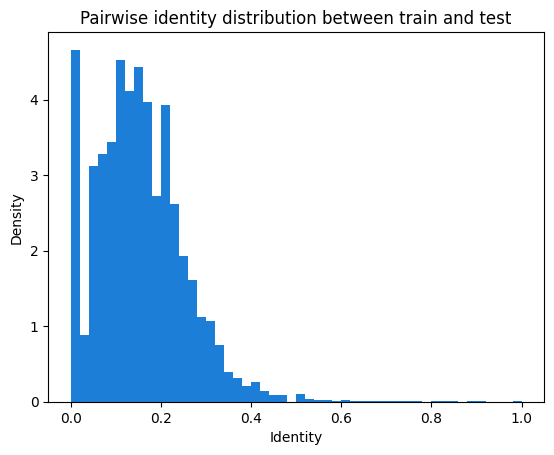

In [10]:
plt.hist(identities.reshape(-1), bins=50, range=(0, 1), density=True)
plt.xlabel("Identity")
plt.ylabel("Density")
plt.title("Pairwise identity distribution between train and test")

In [11]:
print(f"Length of train dataset: {len(train_ids)}")

Length of train dataset: 15218


In [12]:
def generate_esm2_embeddings(protein_sequences: list[str],
                             model_name: str = "facebook/esm2_t33_650M_UR50D",
                             device: str = None,
                             batch_size: int = 512) -> np.ndarray:
    """
    Generate protein embeddings using ESM2 model with mean pooling.

    Args:
        protein_sequences (List[str]): List of protein sequences (amino acid sequences)
        model_name (str): Name of the ESM2 model to use. Options include:
            - "facebook/esm2_t6_8M_UR50D" (8M parameters)
            - "facebook/esm2_t12_35M_UR50D" (35M parameters)
            - "facebook/esm2_t30_150M_UR50D" (150M parameters)
            - "facebook/esm2_t33_650M_UR50D" (650M parameters) - default
            - "facebook/esm2_t36_3B_UR50D" (3B parameters)
            - "facebook/esm2_t48_15B_UR50D" (15B parameters)
        device (str): Device to run the model on ('cuda', 'cpu', or None for auto-detection)
        batch_size (int): Batch size for processing sequences

    Returns:
        np.ndarray: Array of shape (num_sequences, embedding_dim) containing embeddings
                   in the same order as input sequences
    """

    # Set device
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Load tokenizer and model
    tokenizer = EsmTokenizer.from_pretrained(model_name)
    model = EsmModel.from_pretrained(model_name)
    model.to(device)
    model.eval()

    all_embeddings = []

    # Process sequences in batches
    for i in progress(range(0, len(protein_sequences), batch_size)):
        batch_sequences = protein_sequences[i:i + batch_size]

        # Tokenize sequences
        inputs = tokenizer(batch_sequences,
                           return_tensors="pt",
                           padding=True,
                           truncation=True,
                           max_length=1024)

        # Move to device
        inputs = {key: value.to(device) for key, value in inputs.items()}

        # Generate embeddings
        with torch.no_grad():
            outputs = model(**inputs)
            hidden_states = outputs.last_hidden_state  # Shape: (batch_size, seq_len, hidden_size)

        # Process each sequence in the batch
        for j in range(len(batch_sequences)):
            # Get attention mask for this sequence (to exclude padding tokens)
            attention_mask = inputs['attention_mask'][j]
            seq_embeddings = hidden_states[j][attention_mask.bool()]  # Remove padding

            # Remove special tokens (CLS and EOS tokens)
            seq_embeddings_no_special = seq_embeddings[1:-1]  # Remove first (CLS) and last (EOS) tokens

            # Mean pooling
            seq_embedding = seq_embeddings_no_special.mean(dim=0)
            all_embeddings.append(seq_embedding.cpu().numpy())

    return np.array(all_embeddings)

In [32]:
# Get train/test sequences
train_seqs = [sample["Sequence"] for sample in data if sample["ID"] in train_ids]
test_seqs = [sample["Sequence"] for sample in data if sample["ID"] in test_ids]
# Get train/test e coli MIC
train_mic = [sample["Targets"].get("Escherichia coli", (None, ))[0] for sample in data if sample["ID"] in train_ids]
test_mic = [sample["Targets"].get("Escherichia coli", (None, ))[0] for sample in data if sample["ID"] in test_ids]
train_mask = [mic is not None for mic in train_mic]
test_mask = [mic is not None for mic in test_mic]
train_seqs = [seq for seq, mask in zip(train_seqs, train_mask) if mask]
test_seqs = [seq for seq, mask in zip(test_seqs, test_mask) if mask]
train_mic = np.array([mic for mic in train_mic if mic is not None])
test_mic = np.array([mic for mic in test_mic if mic is not None])

# Generate train/test embeddings
train_X = generate_esm2_embeddings(train_seqs, batch_size=128, device="mps")
test_X = generate_esm2_embeddings(test_seqs, batch_size=128, device="mps")
# Train a linear regression model
model = LinearRegression().fit(train_X, np.log10(train_mic))
# Evaluate the model
test_pred = model.predict(test_X)
pcc = pearsonr(test_pred, np.log10(test_mic)).statistic
pcc

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 100%|██████████████████████████████████████████|  86/86 [07:49<00:00, 5.24s/it] 


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 100%|██████████████████████████████████████████|  22/22 [02:09<00:00, 5.53s/it] 


np.float64(0.626055966634892)